The aim in this notebook is to predict the total energy consumption in Germany using prediction time scales between 15 minutes and 24 hours.

First I import the needed python modules. 

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import pmdarima as pm
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

from datetime import date, time, datetime, timedelta

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import pickle

#add fullr and co 
import statsmodels.tsa.stattools as smtime

#We mainly use xgboost
from xgboost import XGBRegressor
import xgboost as xgb

#some skitlearn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

#trials
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import sklearn.metrics as met
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
#needs newest statsmodel 0.14.0 
from statsmodels.tsa.seasonal import MSTL

The data is obtained from https://www.smard.de/home/downloadcenter/download-marktdaten/?downloadAttributes=%7B%22selectedCategory%22:2,%22selectedSubCategory%22:false,%22selectedRegion%22:false,%22selectedFileType%22:false%7D
 using the category 'Stromverbrauch' then the subcategory 'realisierter Stromverbrauch', then 'Deutschland', then the subcategory time intervall 'viertelstunde'.
                   
            
That request gets the power consumption of Germany in the best possible resolution of 15 minutes. To get all availble data (nearly 8 years) it is needed to download in four pieces. 

In [2]:
#path to the data
path='/home/tobias/ml-testing/energy/'
#getting the data which is in four pieces
real_power1=pd.read_csv(path+"Realisierter_Stromverbrauch_202012010000_202211142359.csv",delimiter=';')
real_power4=pd.read_csv(path+"Realisierter_Stromverbrauch_201501010000_201611302359.csv",delimiter=';')
real_power3=pd.read_csv(path+"Realisierter_Stromverbrauch_201612010000_201811302359.csv",delimiter=';')
real_power2=pd.read_csv(path+"Realisierter_Stromverbrauch_201812010000_202011302359.csv",delimiter=';')
real_power5=pd.read_csv(path+"Realisierter_Stromverbrauch_202211150000_202401022359_Viertelstunde.csv",delimiter=';')

We are now printing the columns.

In [3]:
print(real_power1.columns)
print(real_power1.head())
print(real_power5.columns)
print(real_power5.head())
print(real_power5.shape)

Index(['Datum', 'Uhrzeit', 'Gesamt (Netzlast)[MWh]', 'Residuallast[MWh]',
       'Pumpspeicher[MWh]'],
      dtype='object')
        Datum Uhrzeit  Gesamt (Netzlast)[MWh]  Residuallast[MWh]  \
0  01.12.2020   00:00                  14.053              9.295   
1  01.12.2020   00:15                  13.953              9.358   
2  01.12.2020   00:30                  13.842              9.415   
3  01.12.2020   00:45                  13.617              9.387   
4  01.12.2020   01:00                  13.450              9.401   

   Pumpspeicher[MWh]  
0              566.0  
1              529.0  
2              577.0  
3              595.0  
4              450.0  
Index(['Datum', 'Anfang', 'Ende',
       'Gesamt (Netzlast) [MWh] Originalauflösungen',
       'Residuallast [MWh] Originalauflösungen',
       'Pumpspeicher [MWh] Originalauflösungen'],
      dtype='object')
        Datum Anfang   Ende Gesamt (Netzlast) [MWh] Originalauflösungen  \
0  15.11.2022  00:00  00:15                 

They are in German, thus we rename them with a dictionary. Besides dae, time and total power also resiuddal power and pump storage are available

In [4]:
#renaming columns
dic1={'Datum':'Date','Uhrzeit':'Time','Gesamt (Netzlast)[MWh]':'total_power','Residuallast[MWh]':'residual_power','Pumpspeicher[MWh]':'pump_storage'}
real_power1.rename(columns=dic1,inplace=True)
real_power2.rename(columns=dic1,inplace=True)
real_power3.rename(columns=dic1,inplace=True)
real_power4.rename(columns=dic1,inplace=True)
#different rename for newest data frame needed
dic2={'Datum':'Date','Anfang':'Time','Gesamt (Netzlast) [MWh] Originalauflösungen':'total_power','Residuallast [MWh] Originalauflösungen':'residual_power','Pumpspeicher [MWh] Originalauflösungen':'pump_storage'}
real_power5.rename(columns=dic2,inplace=True)
print("columns after dictionary application")
print(real_power1.columns)
print("columns after dictionary application")
#drop columns
real_power5.drop(['Ende'], axis=1, inplace=True)
print(real_power5.columns)

columns after dictionary application
Index(['Date', 'Time', 'total_power', 'residual_power', 'pump_storage'], dtype='object')
columns after dictionary application
Index(['Date', 'Time', 'total_power', 'residual_power', 'pump_storage'], dtype='object')


Convert comma separated float which are interpreted as string to floats. 

In [5]:
print(real_power5.head())
print(real_power5.dtypes)
real_power5['residual_power'] = real_power5['residual_power'].str.replace('.','')
real_power5['residual_power'] = real_power5['residual_power'].str.replace(',','.').astype(float)/1000.
real_power5['total_power'] = real_power5['total_power'].str.replace('.','')
real_power5['total_power'] = real_power5['total_power'].str.replace(',','.').astype(float)/1000.
real_power5['pump_storage'] = real_power5['pump_storage'].str.replace('.','')
real_power5['pump_storage'] = real_power5['pump_storage'].str.replace(',','.').astype(float)/1000.
print(real_power5.dtypes)
print(real_power5.head())

         Date   Time total_power residual_power pump_storage
0  15.11.2022  00:00    11.714,5       7.075,25       584,25
1  15.11.2022  00:15    11.608,5          6.987       619,25
2  15.11.2022  00:30      11.409        6.761,5       698,25
3  15.11.2022  00:45    11.305,5        6.664,5       848,75
4  15.11.2022  01:00    11.307,5       6.725,25        1.104
Date              object
Time              object
total_power       object
residual_power    object
pump_storage      object
dtype: object
Date               object
Time               object
total_power       float64
residual_power    float64
pump_storage      float64
dtype: object
         Date   Time  total_power  residual_power  pump_storage
0  15.11.2022  00:00      11.7145         7.07525       0.58425
1  15.11.2022  00:15      11.6085         6.98700       0.61925
2  15.11.2022  00:30      11.4090         6.76150       0.69825
3  15.11.2022  00:45      11.3055         6.66450       0.84875
4  15.11.2022  01:00      11.30

/tmp/ipykernel_12555/899269472.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  real_power5['residual_power'] = real_power5['residual_power'].str.replace('.','')
/tmp/ipykernel_12555/899269472.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  real_power5['total_power'] = real_power5['total_power'].str.replace('.','')
/tmp/ipykernel_12555/899269472.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  real_power5['pump_storage'] = real_power5['pump_storage'].str.replace('.','')


Now I create a true date time column combining the date and time column and applying datetime methods.

In [6]:
real_power1['date_time']=pd.to_datetime(real_power1['Date'] + '.' + real_power1['Time'], format='%d.%m.%Y.%H:%M')
real_power2['date_time']=pd.to_datetime(real_power2['Date'] + '.' + real_power2['Time'], format='%d.%m.%Y.%H:%M')
real_power3['date_time']=pd.to_datetime(real_power3['Date'] + '.' + real_power3['Time'], format='%d.%m.%Y.%H:%M')
real_power4['date_time']=pd.to_datetime(real_power4['Date'] + '.' + real_power4['Time'], format='%d.%m.%Y.%H:%M')
real_power5['date_time']=pd.to_datetime(real_power5['Date'] + '.' + real_power5['Time'], format='%d.%m.%Y.%H:%M')
print("The columns are")
print(real_power1.columns)
print("data types of columns")
print(real_power1.dtypes)
print(real_power5.dtypes)

The columns are
Index(['Date', 'Time', 'total_power', 'residual_power', 'pump_storage',
       'date_time'],
      dtype='object')
data types of columns
Date                      object
Time                      object
total_power              float64
residual_power           float64
pump_storage             float64
date_time         datetime64[ns]
dtype: object
Date                      object
Time                      object
total_power              float64
residual_power           float64
pump_storage             float64
date_time         datetime64[ns]
dtype: object


As the next step I am combining the four different data sets and show the data in a plot. 

dimensions of the data are (315744, 6)


Text(0, 0.5, 'total power [GW]')

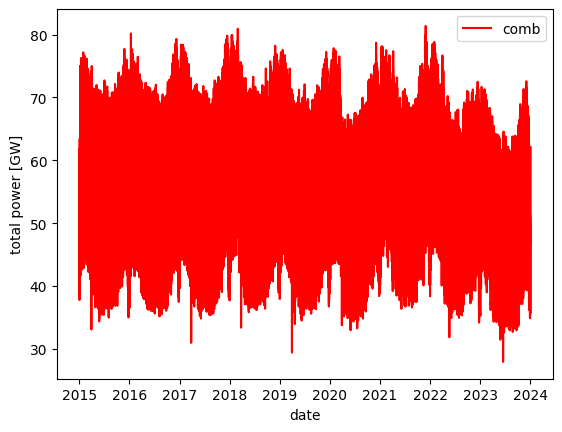

In [7]:
#date_time is set to index
real_power1=real_power1.set_index('date_time')
real_power2=real_power2.set_index('date_time')
real_power3=real_power3.set_index('date_time')
real_power4=real_power4.set_index('date_time')
real_power5=real_power5.set_index('date_time')
#combining with concat
comb_real_power=pd.concat([real_power4,real_power3,real_power2,real_power1,real_power5])
#reset index for easier handling
comb_real_power=comb_real_power.reset_index()
print(f"dimensions of the data are {comb_real_power.shape}")
plt.plot(comb_real_power['date_time'],comb_real_power['total_power']*4,'-',ms=1,color='red',label='comb') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("total power [GW]")

In this plot are visible that there are yearly variations, that the consumption is usually larger in winter than in summer. At the same time it is clear that there are variations also on smaller timescales, since the range at each date is large. That cannot really be variation at a time. To see more of them I zoom in on a week. 

(18604.0, 18611.0)

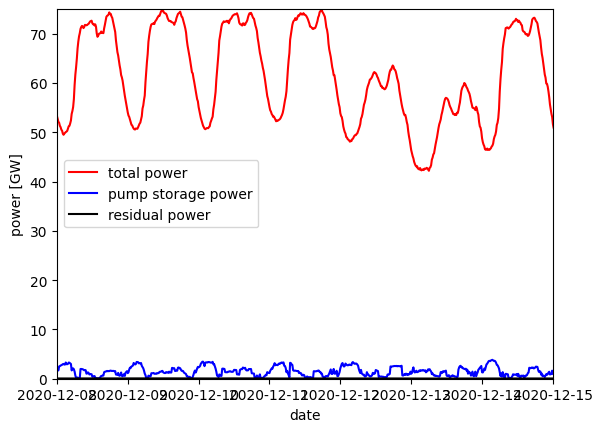

In [8]:
plt.plot(comb_real_power['date_time'],(comb_real_power['total_power']*4),'-',ms=1,color='red',label='total power') 
plt.plot(comb_real_power['date_time'],(comb_real_power['pump_storage']*4/1000),'-',ms=1,color='blue',label='pump storage power') 
plt.plot(comb_real_power['date_time'],(comb_real_power['residual_power']*4/1000),'-',ms=1,color='black',label='residual power') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("power [GW]")
plt.ylim(0,75)
plt.xlim(datetime(2020, 12, 8),datetime(2020, 12, 15))

There are more cycles in the data, the strongest on the day time scale and likely another one on the time scale of a week. 

The periods are day, week and year.  From the 15 minutes sampling follows:

In [9]:
print(f"steps per day: {int(24*60/15)}")
print(f"steps per week: {int(7*24*60/15)}")
print(f"steps per year: {int(365.25*24*60/15)}")

steps per day: 96
steps per week: 672
steps per year: 35064




Below I look again on it this time use a logarithmic y-axis to be able to see more for the other two properties. 

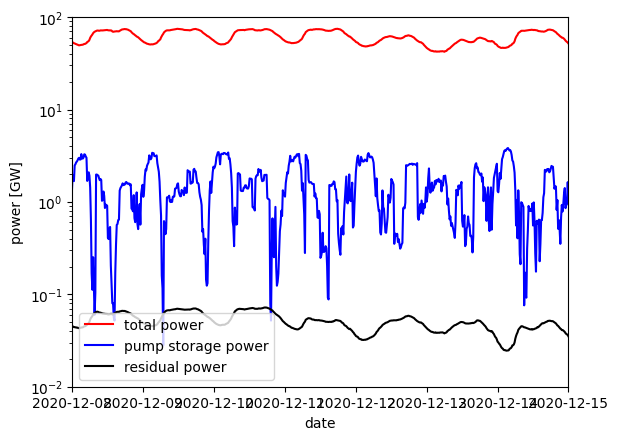

In [10]:
plt.plot(comb_real_power['date_time'],(comb_real_power['total_power']*4),'-',ms=1,color='red',label='total power') 
plt.plot(comb_real_power['date_time'],(comb_real_power['pump_storage']*4/1000),'-',ms=1,color='blue',label='pump storage power') 
plt.plot(comb_real_power['date_time'],(comb_real_power['residual_power']*4/1000),'-',ms=1,color='black',label='residual power') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("power [GW]")
plt.ylim(0.01,100)
plt.xlim(datetime(2020, 12, 8),datetime(2020, 12, 15))
plt.yscale('log')


There is no clear connection of pump storage and residual power to total power and thus we ignore it for now.

As the next step we free space.

In [11]:
size_1=real_power1.shape[0]
size_2=real_power2.shape[0]
size_3=real_power3.shape[0]
size_4=real_power4.shape[0]
size_5=real_power5.shape[0]
real_power1=0
real_power2=0
real_power3=0
real_power4=0
real_power5=0

Now getting the offical predictions. 

In [12]:
pred_power1=pd.read_csv(path+"Prognostizierter_Stromverbrauch_202012010000_202211142359.csv",delimiter=';')
pred_power4=pd.read_csv(path+"Prognostizierter_Stromverbrauch_201501010000_201611302359_Viertelstunde.csv",delimiter=';')
pred_power3=pd.read_csv(path+"Prognostizierter_Stromverbrauch_201612010000_201811302359_Viertelstunde.csv",delimiter=';')
pred_power2=pd.read_csv(path+"Prognostizierter_Stromverbrauch_201812010000_202011302359_Viertelstunde.csv",delimiter=';')
pred_power5=pd.read_csv(path+"Prognostizierter_Stromverbrauch_202211150000_202401022359_Viertelstunde.csv",delimiter=';')

Doing the same conversion as before. 

In [13]:
print(pred_power1.columns)
print(pred_power1.head())
print(pred_power5.columns)
print(pred_power5.head())
#slightly different column terms for coulms which will be different later
print(pred_power5.shape)
dic1b={'Datum':'Date','Uhrzeit':'Time','Gesamt (Netzlast)[MWh]':'total_power_pred','Residuallast[MWh]':'residual_power_pred'}

pred_power1.rename(columns=dic1b,inplace=True)
#here most different because onlyn now gotten
dic2b={'Datum':'Date','Anfang':'Time','Gesamt (Netzlast) [MWh] Originalauflösungen':'total_power_pred','Residuallast [MWh] Originalauflösungen':'residual_power_pred','Pumpspeicher [MWh] Originalauflösungen':'pump_storage'}
pred_power2.rename(columns=dic2b,inplace=True)
pred_power3.rename(columns=dic2b,inplace=True)
pred_power4.rename(columns=dic2b,inplace=True)
pred_power5.rename(columns=dic2b,inplace=True)
print("columns after dictionary application")
print(pred_power1.columns)
print("columns after dictionary application")
#drop columns
pred_power2.drop(['Ende'], axis=1, inplace=True)
pred_power3.drop(['Ende'], axis=1, inplace=True)
pred_power4.drop(['Ende'], axis=1, inplace=True)
pred_power5.drop(['Ende'], axis=1, inplace=True)
print(pred_power5.columns)
print(pred_power1.total_power_pred.value_counts())
print(pred_power2.total_power_pred.value_counts())
print(pred_power3.total_power_pred.value_counts())
print(pred_power4.total_power_pred.value_counts())
print(pred_power5.total_power_pred.value_counts())

Index(['Datum', 'Uhrzeit', 'Gesamt (Netzlast)[MWh]', 'Residuallast[MWh]'], dtype='object')
        Datum Uhrzeit  Gesamt (Netzlast)[MWh]  Residuallast[MWh]
0  01.12.2020   00:00                  12.944              7.608
1  01.12.2020   00:15                  12.771              7.491
2  01.12.2020   00:30                  12.667              7.453
3  01.12.2020   00:45                  12.541              7.403
4  01.12.2020   01:00                  12.370              7.319
Index(['Datum', 'Anfang', 'Ende',
       'Gesamt (Netzlast) [MWh] Originalauflösungen',
       'Residuallast [MWh] Originalauflösungen'],
      dtype='object')
        Datum Anfang   Ende Gesamt (Netzlast) [MWh] Originalauflösungen  \
0  15.11.2022  00:00  00:15                                   12.444,25   
1  15.11.2022  00:15  00:30                                   12.333,25   
2  15.11.2022  00:30  00:45                                   12.309,25   
3  15.11.2022  00:45  01:00                                

Some - no value, is reapced by 0 but most ignored later. 

In [14]:
#some are - no data I assume, thus not all can be used 
pred_power2['residual_power_pred'] = pred_power2['residual_power_pred'].str.replace('.','').str.replace('-','0')
pred_power2['residual_power_pred'] = pred_power2['residual_power_pred'].str.replace(',','.').astype(float)/1000.
pred_power2['total_power_pred'] = pred_power2['total_power_pred'].str.replace('.','').str.replace('-','0')
pred_power2['total_power_pred'] = pred_power2['total_power_pred'].str.replace(',','.').astype(float)/1000.
pred_power3['residual_power_pred'] = pred_power3['residual_power_pred'].str.replace('.','').str.replace('-','0')
pred_power3['residual_power_pred'] = pred_power3['residual_power_pred'].str.replace(',','.').astype(float)/1000.
pred_power3['total_power_pred'] = pred_power3['total_power_pred'].str.replace('.','').str.replace('-','0')
pred_power3['total_power_pred'] = pred_power3['total_power_pred'].str.replace(',','.').astype(float)/1000.
pred_power4['residual_power_pred'] = pred_power4['residual_power_pred'].str.replace('.','').str.replace('-','0')
pred_power4['residual_power_pred'] = pred_power4['residual_power_pred'].str.replace(',','.').astype(float)/1000.
pred_power4['total_power_pred'] = pred_power4['total_power_pred'].str.replace('.','').str.replace('-','0')
pred_power4['total_power_pred'] = pred_power4['total_power_pred'].str.replace(',','.').astype(float)/1000.
pred_power5['residual_power_pred'] = pred_power5['residual_power_pred'].str.replace('.','').str.replace('-','0')
pred_power5['residual_power_pred'] = pred_power5['residual_power_pred'].str.replace(',','.').astype(float)/1000.
pred_power5['total_power_pred'] = pred_power5['total_power_pred'].str.replace('.','').str.replace('-','0')
pred_power5['total_power_pred'] = pred_power5['total_power_pred'].str.replace(',','.').astype(float)/1000.

/tmp/ipykernel_12555/2489085657.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pred_power2['residual_power_pred'] = pred_power2['residual_power_pred'].str.replace('.','').str.replace('-','0')
/tmp/ipykernel_12555/2489085657.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pred_power2['total_power_pred'] = pred_power2['total_power_pred'].str.replace('.','').str.replace('-','0')
/tmp/ipykernel_12555/2489085657.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pred_power3['residual_power_pred'] = pred_power3['resi

In [15]:
pred_power1['date_time']=pd.to_datetime(pred_power1['Date'] + '.' + pred_power1['Time'], format='%d.%m.%Y.%H:%M')
pred_power2['date_time']=pd.to_datetime(pred_power2['Date'] + '.' + pred_power2['Time'], format='%d.%m.%Y.%H:%M')
pred_power3['date_time']=pd.to_datetime(pred_power3['Date'] + '.' + pred_power3['Time'], format='%d.%m.%Y.%H:%M')
pred_power4['date_time']=pd.to_datetime(pred_power4['Date'] + '.' + pred_power4['Time'], format='%d.%m.%Y.%H:%M')
pred_power5['date_time']=pd.to_datetime(pred_power5['Date'] + '.' + pred_power5['Time'], format='%d.%m.%Y.%H:%M')
print("The columns are")
print(pred_power1.columns)
print("data types of columns")
print(pred_power1.dtypes)
print(pred_power5.dtypes)

The columns are
Index(['Date', 'Time', 'total_power_pred', 'residual_power_pred', 'date_time'], dtype='object')
data types of columns
Date                           object
Time                           object
total_power_pred              float64
residual_power_pred           float64
date_time              datetime64[ns]
dtype: object
Date                           object
Time                           object
total_power_pred              float64
residual_power_pred           float64
date_time              datetime64[ns]
dtype: object


In [16]:
#date_time is set to index
pred_power1=pred_power1.set_index('date_time')
pred_power2=pred_power2.set_index('date_time')
pred_power3=pred_power3.set_index('date_time')
pred_power4=pred_power4.set_index('date_time')
pred_power5=pred_power5.set_index('date_time')
#combining with concat
comb_pred_power=pd.concat([pred_power4,pred_power3,pred_power2,pred_power1,pred_power5])
#reset index for easier handling
comb_pred_power=comb_pred_power.reset_index()
print(f"dimensions of the data are {comb_real_power.shape} and {comb_pred_power.shape}")
comb_real_power.loc[0:comb_pred_power.shape[0],['total_power_pred','residual_power_pred']]=comb_pred_power.loc[:,['total_power_pred','residual_power_pred']]
#free storage
pred_power1=0
pred_power2=0
pred_power3=0
pred_power4=0
pred_power5=0
comb_pred_power=0
print(f"dimensions of the data are {comb_real_power.shape} and {comb_pred_power}")

dimensions of the data are (315744, 6) and (315744, 5)
dimensions of the data are (315744, 8) and 0


Same shapes as they should be (will be differnt at some point when future official prediction is included.)
Now looking on goodness of prediction. 

Text(0, 0.5, 'total power [GW]')

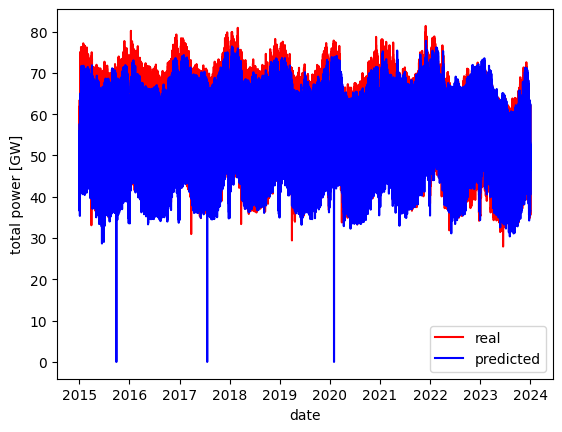

In [17]:
plt.plot(comb_real_power['date_time'],comb_real_power['total_power']*4,'-',ms=1,color='red',label='real') 
plt.plot(comb_real_power['date_time'],comb_real_power['total_power_pred']*4,'-',ms=1,color='blue',label='predicted') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("total power [GW]")

Some rather random times with no data. Excludeded for statistic. 

In [18]:
print(comb_real_power[(comb_real_power.total_power_pred!=0)].total_power.describe())
print(comb_real_power[(comb_real_power.total_power_pred!=0)].total_power_pred.describe())
print((comb_real_power[(comb_real_power.total_power_pred!=0)].total_power/comb_real_power[(comb_real_power.total_power_pred!=0)].total_power_pred).describe())

count    315360.000000
mean         14.101984
std           2.501620
min           6.984750
25%          12.042000
50%          14.019000
75%          16.195000
max          20.342000
Name: total_power, dtype: float64
count    315360.000000
mean         13.701217
std           2.356878
min           7.168750
25%          11.776250
50%          13.681375
75%          15.705000
max          19.438000
Name: total_power_pred, dtype: float64
count    315360.000000
mean          1.029351
std           0.045204
min           0.724605
25%           1.001926
50%           1.030443
75%           1.057094
max           1.372226
dtype: float64


4.5% standard deviation, 5.5% interquartile range for the prediction also in average 3% too small, thus not prefect prediction. 
Adding fractions used unit columns now. 

In [22]:
time1=np.zeros((comb_real_power.shape[0],5))
for i in range(comb_real_power.shape[0]):
    time1[i,0]=i/4/24
    time1[i,1]=time1[i,0]%1
    time1[i,2]=(time1[i,0]%7)/7
    time1[i,3]=(time1[i,0]%365.25)/365.25
    time1[i,4]=i/4/24/365.25  
print(time1)    
comb_real_power['frac_day']=time1[:,1]
comb_real_power['frac_week']=time1[:,2]
comb_real_power['frac_year']=time1[:,3]

print(comb_real_power.describe())
#later also real daya and easter but for now just using the current model to predict

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.04166667e-02 1.04166667e-02 1.48809524e-03 2.85192790e-05
  2.85192790e-05]
 [2.08333333e-02 2.08333333e-02 2.97619048e-03 5.70385581e-05
  5.70385581e-05]
 ...
 [3.28896875e+03 9.68750000e-01 8.52678571e-01 4.70568104e-03
  9.00470568e+00]
 [3.28897917e+03 9.79166667e-01 8.54166667e-01 4.73420032e-03
  9.00473420e+00]
 [3.28898958e+03 9.89583333e-01 8.55654762e-01 4.76271960e-03
  9.00476272e+00]]
         total_power  residual_power   pump_storage  total_power_pred  \
count  315744.000000   315744.000000  315744.000000     315744.000000   
mean       14.101555        9.885544     207.012504         13.684554   
std         2.501696       13.365981     264.747801          2.403361   
min         6.984750       -1.545000       0.000000          0.000000   
25%        12.042000        7.574000       1.637437         11.770500   
50%        14.017625        9.799000      76.000000         13.676500   
75%

 I choose for fitting the two efficient options XGBoost regressor and linear regression. 

Xgboost needs to have the data transformed into the usual supervised data structure. Therefore, I use a function which uses some continous data block to predict one future data point. There can be a gap between the used data and the predicted data point or no gap. 

In [23]:
#parameters are: 
#data_frame, number of data points used for prediction, number of data points ignored between data and target, nan excluding
def series_to_supervised(data, n_in=1, offset=0, dropnan=True):
    #create empty data frame and list
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t+offset)
    for i in range(offset, 1+offset):
        cols.append(df.shift(-i))
    # connecting all 
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

I construct a function for this purpose.  Since the fitting takes time the result is saved.

In [24]:
#parameters, data, min time pred period in hours/4-1/4, max-min time pred peiod in hours/4-1/4, predictining over how many data_points
#steps in test, model shortcut used, name of file for output
def predict_intervall(df,a,b,c,d,model,output):
    resf=np.zeros((4,b))
    #valid_modelchecks whether model is called
    valid_model=False
    if model=="xgb" or model=="xgboost":
        xmodel3=XGBRegressor()
        print("running XGBoost")
        valid_model=True
    if model=="lin" or model=='linear':
        xmodel3=LinearRegression()
        print("running Linear Regression")
        valid_model=True
    if valid_model==True:
        for i in range(int(a), int(b+a)):
            print(f"running prediction over {(i+1)*15} minutes")
            #convert to supervised data format
            res3=series_to_supervised(df.total_power,c,i)
            res3=pd.DataFrame(res3)
            #split in test and train
            dataa3_train = res3.iloc[:-d,:]
            dataa3_test  = res3.iloc[-d:,:]
            x3_train=dataa3_train.iloc[:,:c]
            x3_test=dataa3_test.iloc[:,:c]
            y3_train=dataa3_train.iloc[:,c]
            y3_test=dataa3_test.iloc[:,c]
            #time scale of prediction
            resf[0,i-int(a)]=15*(i+1)
            #fit and predict
            xmodel3.fit(x3_train,y3_train)
            pred3=xmodel3.predict(x3_test)
            #standard deviation of prediction
            resf[2,i-int(a)]=np.std(pred3-y3_test)
            #compare with shift
            diff6=y3_test.shift(periods=i+1)           
            resf[1,i-int(a)]=np.std(diff6-y3_test)
            #mean value to get percentage
            resf[3,i-int(a)]=np.mean(y3_test)
    else:
        print("no implemented model called")
    np.savetxt(output,resf)

Now XGBoost to the 9 year data set. The same final about 20 weeks are used for tested to avoid that the test period variationsinfluences the result. 

In [25]:
#slow and not so important, main point is to repeat MTSL and get prediction ready 
#predict_intervall(comb_real_power,0,96,96,13250,"xgb",'xgb_1day_9year_v1.txt')

In [26]:
#linear on 9 year clearly faster
#predict_intervall(comb_real_power,0,96,96,13250,"linear",'linear_1day_9year_v1.txt')

Now using a full week for prediction, on linear which is faster. 

In [27]:
#does not work  too much memry at leats when at once are done
#predict_intervall(comb_real_power,0,96,672,13250,"linear",'linear_1week_9year_v1.txt')

I also tried using the previous week with the full 8 year data set. However, that did not work, because of limited memory of my laptop. 

Below I compare the different predictions and the different shifts. (Wekk not included because done with other test data) 

4.2 % are used in test


Text(0, 0.5, 'standard deviation (x-data)/data %')

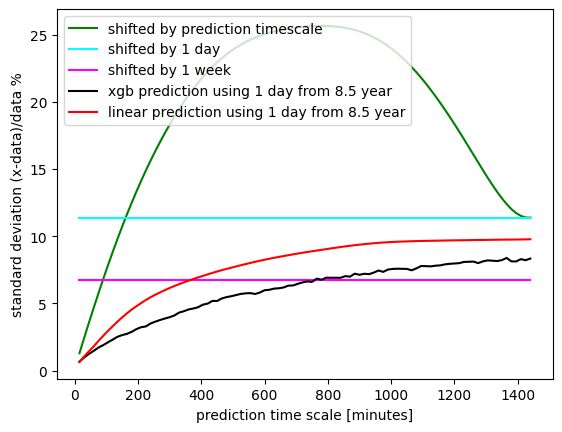

In [30]:
pred_from_9yearsweek=np.loadtxt("xgb_1week_v1.txt")
pred_from_9years=np.loadtxt('xgb_1day_9year_v1.txt')
pred_from_9years_li=np.loadtxt('linear_1day_9year_v1.txt')
power_9years=series_to_supervised(comb_real_power.total_power,96,0)
power_9years=pd.DataFrame(power_9years)
steps = 13250
print(f"{round(steps/power_9years.shape[0]*100,2)} % are used in test")
data_train = power_9years.iloc[:-steps,:]
data_test  = power_9years.iloc[-steps:,:]
x_train=data_train.iloc[:,0:96]
x_test=data_test.iloc[:,0:96]
y_train=data_train.iloc[:,96]
y_test=data_test.iloc[:,96]

shift_15min=y_test.shift(periods=1)
shift_1day=y_test.shift(periods=96)
shift_1week=y_test.shift(periods=672)
plt.plot(pred_from_9years[0],100*pred_from_9years[1]/pred_from_9years[3],'-',ms=1,color='green',label='shifted by prediction timescale') 
plt.plot(pred_from_9years[0],0*pred_from_9years[1]+100*np.std(shift_1day-y_test)/np.mean(y_test),'-',ms=1,color='cyan',label='shifted by 1 day')
plt.plot(pred_from_9years[0],0*pred_from_9years[1]+100*np.std(shift_1week-y_test)/np.mean(y_test),'-',ms=1,color='magenta',label='shifted by 1 week') 
plt.plot(pred_from_9years[0],100*pred_from_9years[2]/pred_from_9years[3],'-',ms=1,color='black',label='xgb prediction using 1 day from 8.5 year')
plt.plot(pred_from_9years_li[0],100*pred_from_9years_li[2]/pred_from_9years_li[3],'-',ms=1,color='red',label='linear prediction using 1 day from 8.5 year') 
#plt.plot(pred_from_2yearsweek[0],100*pred_from_2yearsweek[2]/pred_from_2years[3],'-',ms=1,color='red',label='prediction using 1 week from 2 years') 
plt.legend(loc="best")
plt.xlabel("prediction time scale [minutes]")
plt.ylabel("standard deviation (x-data)/data %")


9 years uses different test time frame, so not comparable. 

Text(0, 0.5, 'standard deviation (x-data)/data %')

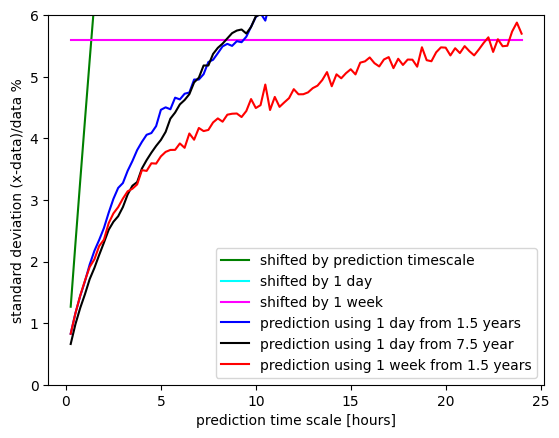

In [16]:
plt.plot(pred_from_2years[0]/60,100*pred_from_2years[1]/pred_from_2years[3],'-',ms=1,color='green',label='shifted by prediction timescale') 
plt.plot(pred_from_2years[0]/60,0*pred_from_2years[1]+100*np.std(shift_1day-y_test)/np.mean(y_test),'-',ms=1,color='cyan',label='shifted by 1 day')
plt.plot(pred_from_2years[0]/60,0*pred_from_2years[1]+100*np.std(shift_1week-y_test)/np.mean(y_test),'-',ms=1,color='magenta',label='shifted by 1 week') 
plt.plot(pred_from_2years[0]/60,100*pred_from_2years[2]/pred_from_2years[3],'-',ms=1,color='blue',label='prediction using 1 day from 1.5 years') 
plt.plot(pred_from_9years[0]/60,100*pred_from_9years[2]/pred_from_9years[3],'-',ms=1,color='black',label='prediction using 1 day from 7.5 year') 
plt.plot(pred_from_2yearsweek[0]/60,100*pred_from_2yearsweek[2]/pred_from_2years[3],'-',ms=1,color='red',label='prediction using 1 week from 1.5 years') 
plt.legend(loc="best")
plt.xlabel("prediction time scale [hours]")
plt.ylim(0,6)
plt.ylabel("standard deviation (x-data)/data %")

As the next plot, I show the zoom to small time scales.  

(0.0, 5.0)

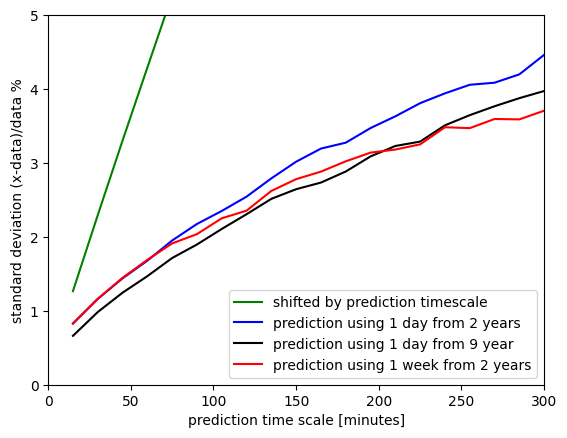

In [18]:
plt.plot(pred_from_2years[0],100*pred_from_2years[1]/pred_from_2years[3],'-',ms=1,color='green',label='shifted by prediction timescale') 
plt.plot(pred_from_2years[0],100*pred_from_2years[2]/pred_from_2years[3],'-',ms=1,color='blue',label='prediction using 1 day from 2 years') 
plt.plot(pred_from_9years[0],100*pred_from_9years[2]/pred_from_9years[3],'-',ms=1,color='black',label='prediction using 1 day from 9 year') 
plt.plot(pred_from_2yearsweek[0],100*pred_from_2yearsweek[2]/pred_from_2years[3],'-',ms=1,color='red',label='prediction using 1 week from 2 years') 
plt.legend(loc="best")
plt.xlabel("prediction time scale [minutes]")
plt.ylabel("standard deviation (x-data)/data %")
plt.xlim(0,300)
plt.ylim(0,5)

The prediction which uses 1 day but uses about 9 years of data performs better than both other for time scales smaller than about 4 hours but only by a rather small factor. For more than 4 hours the prediction using 1 week over about 2 years is best. That shows that the week time scale is important for large time scales, on small time scales a prediction which uses only the last day is also good. That is understandable since for small time scales weekday effect and holiday effects or not important; the rerve is true for larger time scales. 

To consider the several periods at once I now use Multiple Seasonal-Trend decomposition using LOESS (MSTL) which is included in the nwest version of statsmodel.
I always  use the 8 year data set because 2 years are not enough data for a reliable yearly period. 


First, I exclude the test set as usual. 

In [31]:
steps=13250
power_train = comb_real_power.total_power.iloc[:-steps]
power_train_pred = comb_real_power.total_power_pred.iloc[:-steps]
power_test  = comb_real_power.total_power.iloc[-steps:]
power_test_pred  = comb_real_power.total_power_pred.iloc[-steps:]

Then MSTL is then run with the 3 periods of day, wek and year and LOESS seasonal degree of 0. The fit takes some time, therefore the result is saved as pickle.  

In [32]:

#deg = {"seasonal_deg": 0} 
#modelms = MSTL(power_train, periods=(24*4, 24 * 7*4,int(365.25*24*4)), stl_kwargs=deg)
#protected because it takes time
#resms = modelms.fit()
#with open('mstl_v1b.pkl', 'wb') as pkl:
    #pickle.dump(resms, pkl)
#other parametsr like box-corr could be optimized

In [33]:
with open('mstl_v1b.pkl', 'rb') as f:
    # unpickle
    mstl1 = pickle.load(f)
seasonal = mstl1.seasonal # contains 3 seasonal components
trend = mstl1.trend
residual = mstl1.resid

In [34]:
print(f"standard deviation over the training data set is {round(100*np.std(residual)/np.mean(power_train),2)} %") 

standard deviation over the training data set is 3.79 %


The fit is rather good with abot 3.79 % standard deviation, that is clearly better than shifting by week and it is better than the 4.5 % of the official prediction.

We now visilize the long term trend and yearly variation. 

Text(0, 0.5, 'total power [MW]')

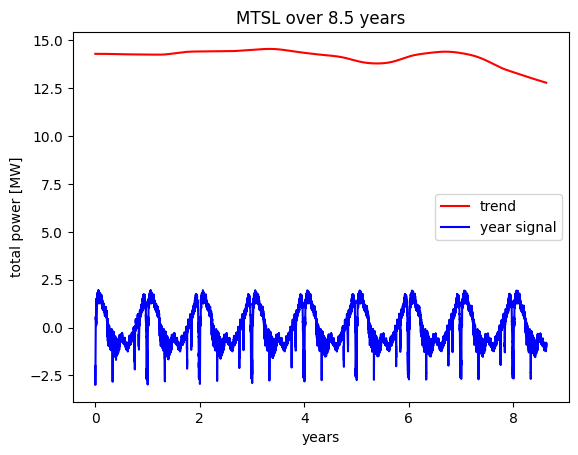

In [35]:
years=np.arange(0,trend.shape[0]/24/4/365.25,1/24/4/365.25)
plt.plot(years,trend,'-',ms=1,color='red',label='trend') 
plt.plot(years,seasonal.iloc[:,2],'-',ms=1,color='blue',label='year signal') 
plt.legend(loc="best")
plt.xlabel("years")
plt.title("MTSL over 8.5 years")
plt.ylabel("total power [MW]")

The main variation in the year is as expected that is more power needed in the winter. In addition, also holidays, most clearly Christmas, are visible here. 

On the next plot the dayly and weekly variation can be seen. 

(7.0, 14.0)

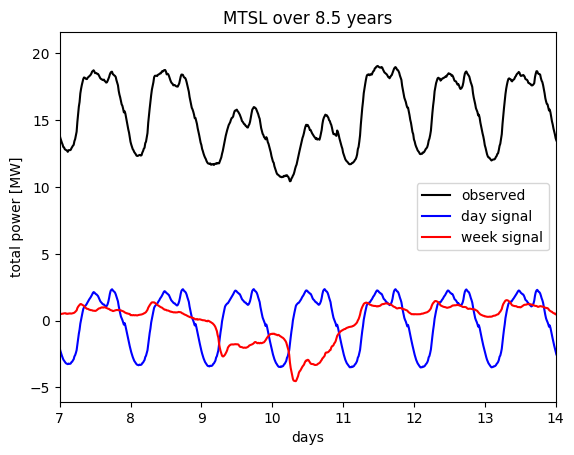

In [36]:
ti2=np.arange(0,seasonal.shape[0]/24/4,1/24/4)
plt.plot(ti2,power_train,'-',ms=1,color='black',label='observed') 
plt.plot(ti2,seasonal.iloc[:,0],'-',ms=1,color='blue',label='day signal') 
plt.plot(ti2,seasonal.iloc[:,1],'-',ms=1,color='red',label='week signal') 
plt.legend(loc="best")
plt.xlabel("days")
plt.title("MTSL over 8.5 years")
plt.ylabel("total power [MW]")
plt.xlim(7,14)

Now I compare the total fit with the data. 

(10.0, 20.0)

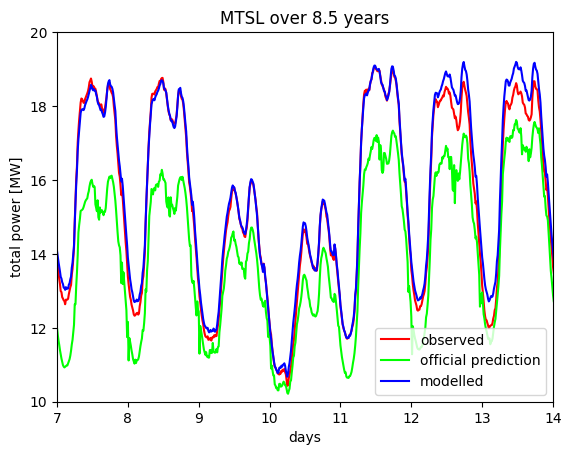

In [37]:
plt.plot(ti2,power_train,'-',ms=1,color='red',label='observed') 
plt.plot(ti2,power_train_pred,'-',ms=1,color='lime',label='official prediction') 
plt.plot(ti2,seasonal.iloc[:,0]+seasonal.iloc[:,1]+seasonal.iloc[:,2]+trend,'-',ms=1,color='blue',label='modelled') 
plt.legend(loc="best")
plt.xlabel("days")
plt.title("MTSL over 8.5 years")
plt.ylabel("total power [MW]")
plt.xlim(7,14)
plt.ylim(10,20)

(8.0, 18.0)

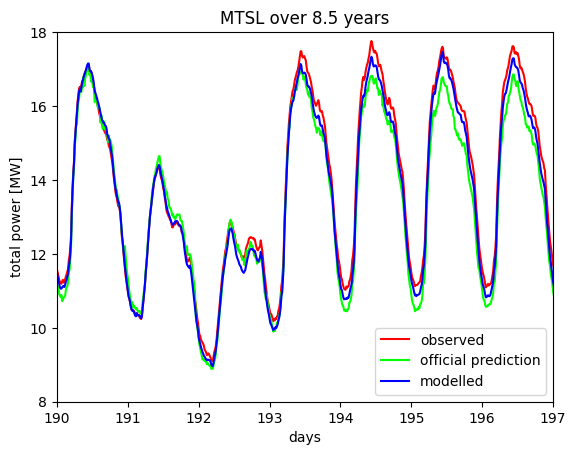

In [38]:
plt.plot(ti2,power_train,'-',ms=1,color='red',label='observed') 
plt.plot(ti2,power_train_pred,'-',ms=1,color='lime',label='official prediction') 
plt.plot(ti2,seasonal.iloc[:,0]+seasonal.iloc[:,1]+seasonal.iloc[:,2]+trend,'-',ms=1,color='blue',label='modelled') 
plt.legend(loc="best")
plt.xlabel("days")
plt.title("MTSL over 8.5 years")
plt.ylabel("total power [MW]")
plt.xlim(190,197)
plt.ylim(8,18)

Usually, mymodel is good usually better than the offocial prediction. The expection is around Easter and other with it connected holidays, see below, because the date of Eatser is variable. 

(9.0, 19.0)

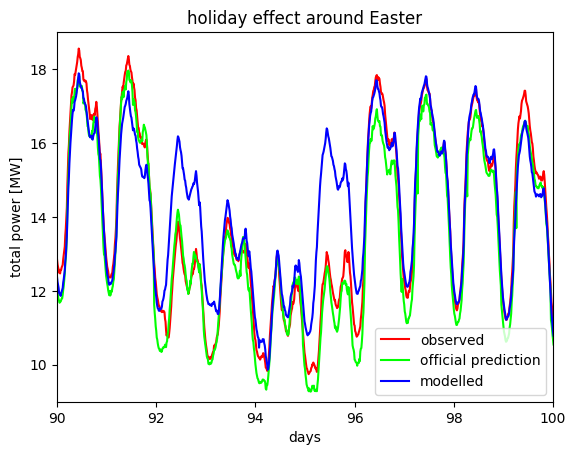

In [39]:
plt.plot(ti2,power_train,'-',ms=1,color='red',label='observed') 
plt.plot(ti2,power_train_pred,'-',ms=1,color='lime',label='official prediction') 
plt.plot(ti2,seasonal.iloc[:,0]+seasonal.iloc[:,1]+seasonal.iloc[:,2]+trend,'-',ms=1,color='blue',label='modelled') 
plt.legend(loc="best")
plt.xlabel("days")
plt.title("holiday effect around Easter")
plt.ylabel("total power [MW]")
plt.xlim(90,100)
plt.ylim(9,19)

There the official prediction is usually better, likely because the effect is considered. 

Could get residuals as function of date time of day/week/year to see what is the main problem  

Now I fit all the data. 

In [40]:
#now fitting full data as test how much it chances then and since I am not sure how to predict
#deg = {"seasonal_deg": 0} 
#modelms = MSTL(comb_real_power.total_power, periods=(24*4, 24 * 7*4,int(365.25*24*4)), stl_kwargs=deg)
#start 21:04
#resms = modelms.fit()
#with open('mstl_v2b.pkl', 'wb') as pkl:
#    pickle.dump(resms, pkl)

In [41]:
with open('mstl_v2b.pkl', 'rb') as f:
    # unpickle
    resms2 = pickle.load(f)
seasonal2 = resms2.seasonal # contains 3 seasonal components
trend2 = resms2.trend
residual2 = resms2.resid 

Text(0, 0.5, 'total power [MW]')

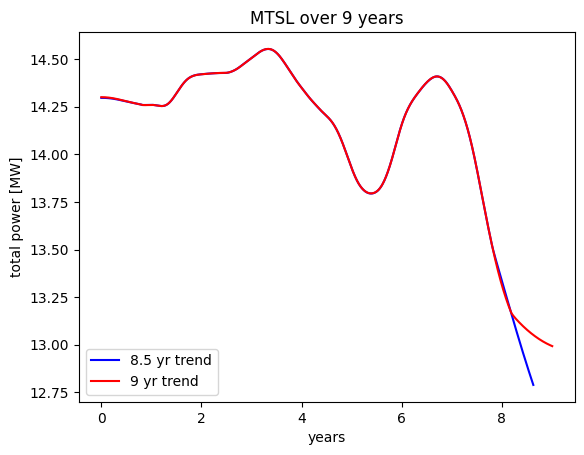

In [42]:
years2=np.arange(0,trend2.shape[0]/24/4/365.25,1/24/4/365.25)
plt.plot(years,trend,'-',ms=1,color='blue',label='8.5 yr trend') 
plt.plot(years2,trend2,'-',ms=1,color='red',label='9 yr trend') 
plt.legend(loc="best")
plt.xlabel("years")
plt.title("MTSL over 9 years")
plt.ylabel("total power [MW]")


In the most recent data there is a difference in the trend. This does not matter for testing MSTL, because that is a nearly constant offset which can be easily modelled with little data. 

I now I look into the deviation between the year term


(8.0, 9.01)

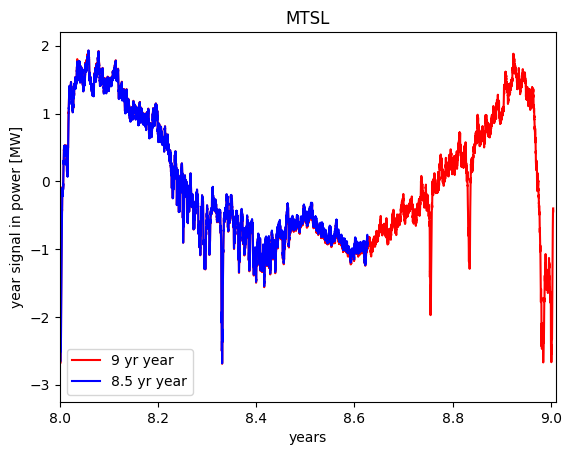

In [43]:
plt.plot(years2,seasonal2.iloc[:,2],'-',ms=1,color='red',label='9 yr year') 
plt.plot(years,seasonal.iloc[:,2],'-',ms=1,color='blue',label='8.5 yr year') 
plt.legend(loc="best")
plt.xlabel("years")
plt.title("MTSL")
plt.ylabel("year signal in power [MW]")
plt.xlim(8,9.01)


There is none visiually. Therefor, I now caluclate the difference quantiatively.

In [44]:
print("standard deviation bewteen seasonal models for the diffrence periods")
start_bin=seasonal2.shape[0]-trend.shape[0]
print(f"{round(np.std(seasonal.iloc[:,2]-seasonal2.iloc[:trend.shape[0],2])/np.mean(power_train)*100,2)} % deviation for year model")
print(f"{round(np.std(seasonal.iloc[start_bin:,2]-seasonal2.iloc[start_bin:trend.shape[0],2])/np.mean(power_train)*100,2)} % deviation for year model in 9th year")
print(f"{round(np.std(seasonal.iloc[:,1]-seasonal2.iloc[:trend.shape[0],1])/np.mean(power_train)*100,2)} % deviation for week model")
print(f"{round(np.std(seasonal.iloc[start_bin:,1]-seasonal2.iloc[start_bin:trend.shape[0],1])/np.mean(power_train)*100,2)} % deviation for week model in 9th year")
print(f"{round(np.std(seasonal.iloc[:,0]-seasonal2.iloc[:trend.shape[0],0])/np.mean(power_train)*100,2)} % deviation for day model")
print(f"{round(np.std(seasonal.iloc[start_bin:,0]-seasonal2.iloc[start_bin:trend.shape[0],0])/np.mean(power_train)*100,2)} % deviation for day model in 9th year")

standard deviation bewteen seasonal models for the diffrence periods
0.21 % deviation for year model
0.21 % deviation for year model in 9th year
0.06 % deviation for week model
0.06 % deviation for week model in 9th year
0.02 % deviation for day model
0.02 % deviation for day model in 9th year


The deviation for of year, week and day models are small at most 0.21%. Thus using the full data for training MTSL has only a very minor impact on model testing. The day resiual is very small which means that the impact on the prediction below which uses only the last 1-2 day is very small.  

The deviation seems small but it needs to be compared with how good the model is. That is calculated in the following

In [45]:
residual2_train = residual2.iloc[:-steps]
residual2_test  = residual2.iloc[-steps:]
print("standard deviation of residua after MTSL fitting")
print(f"train: {round(100*np.std(residual2_train)/np.mean(power_train),2)}% test: {round(100*np.std(residual2_test)/np.mean(power_test),2)}%")

standard deviation of residua after MTSL fitting
train: 3.79% test: 3.0%


This scatter is more than 10 times larger. Thus, the differences between the sesonal models do not matter and the trend difefrence is not relevant for short and medium term prediction. 

The scatter is smaller in the test data set than in train set. Thus there is likely no overfitting of MTSL. Likely, also contributing to the sign of the difference is that the main movable holidays associated with Easter are in the first half of the year which is not in test. 

As the next step I try to further optimize the prediction by using the following models on the residual:
1. Shifting just to the last data allowed
2. linear regression
3. XGboost

In [46]:
residua=residual2.to_numpy()

First for linear regression as before each number of explore future prediction step (15 minutes to 1 day) separately. Uses for prediction always the full last day. 

In [47]:
def res_pred(residua,steps=13250,steps_used=96,minsteps=0,maxsteps=96,method='linear',file_name='linear_1day_8yr_mtsl_residua_v2.txt',reg=0):
    resf=np.zeros((4,(maxsteps-minsteps)))
    steps = 13250
    for i in range(minsteps, maxsteps):
        print(f"prediction for {i} steps")
        #meaning default is one day the number of possible_steps , max_step means up to one day in future can fore
        res3=series_to_supervised(residua,steps_used,i)
        res3=pd.DataFrame(res3)
        dataa3_train = res3.iloc[:-steps,:]
        dataa3_test  = res3.iloc[-steps:,:]
        x3_train=dataa3_train.iloc[:,0:steps_used]
        x3_test=dataa3_test.iloc[:,0:steps_used]
        y3_train=dataa3_train.iloc[:,steps_used]
        y3_test=dataa3_test.iloc[:,steps_used]
        resf[0,i-minsteps]=15*(i+1)
        if method=='linear':
            if reg==0:
                model=LinearRegression()
            else:
                #L1 not sparse regularization 
                model=Lasso(alpha=reg)
        if method=='xgboost':             
            model=XGBRegressor()
        #now fitting it    
        model.fit(x3_train,y3_train)
        pred3=model.predict(x3_test)
        diff6=y3_test.shift(periods=i+1) #this shifts the data using the last allowed data point
        resf[2,i-minsteps]=np.std(pred3-y3_test)
        resf[1,i-minsteps]=np.std(diff6-y3_test)
        resf[3,i-minsteps]=np.mean(y3_test)
    np.savetxt(file_name,resf) 

Fit linear which is fast. 

In [ ]:
#2b is from 2 to 4 days   2c 1 to 2 days 
#just using 2 steps is already very similar to using 96 
res_pred(residua,steps_used=192,minsteps=0,maxsteps=96*2,steps=13250,method='linear',file_name='linear_2day_9yr_mtsl_residua_v2.txt')

prediction for 0 steps
prediction for 1 steps
prediction for 2 steps
prediction for 3 steps
prediction for 4 steps
prediction for 5 steps
prediction for 6 steps
prediction for 7 steps
prediction for 8 steps
prediction for 9 steps
prediction for 10 steps
prediction for 11 steps
prediction for 12 steps
prediction for 13 steps
prediction for 14 steps
prediction for 15 steps
prediction for 16 steps
prediction for 17 steps
prediction for 18 steps
prediction for 19 steps
prediction for 20 steps
prediction for 21 steps
prediction for 22 steps
prediction for 23 steps
prediction for 24 steps
prediction for 25 steps
prediction for 26 steps
prediction for 27 steps
prediction for 28 steps
prediction for 29 steps
prediction for 30 steps
prediction for 31 steps
prediction for 32 steps
prediction for 33 steps
prediction for 34 steps
prediction for 35 steps
prediction for 36 steps
prediction for 37 steps
prediction for 38 steps
prediction for 39 steps
prediction for 40 steps
prediction for 41 steps
pr

Now some regularized linear. 

In [66]:
res_pred(residua,reg=0.01,steps=13250,method='linear',file_name='linear_1day_9yr_mtsl_residua_a_0.01.txt')

prediction for 0 steps
prediction for 1 steps
prediction for 2 steps
prediction for 3 steps
prediction for 4 steps
prediction for 5 steps
prediction for 6 steps
prediction for 7 steps
prediction for 8 steps
prediction for 9 steps
prediction for 10 steps
prediction for 11 steps
prediction for 12 steps
prediction for 13 steps
prediction for 14 steps
prediction for 15 steps
prediction for 16 steps
prediction for 17 steps
prediction for 18 steps
prediction for 19 steps
prediction for 20 steps
prediction for 21 steps
prediction for 22 steps
prediction for 23 steps
prediction for 24 steps
prediction for 25 steps
prediction for 26 steps
prediction for 27 steps
prediction for 28 steps
prediction for 29 steps
prediction for 30 steps
prediction for 31 steps
prediction for 32 steps
prediction for 33 steps
prediction for 34 steps
prediction for 35 steps
prediction for 36 steps
prediction for 37 steps
prediction for 38 steps
prediction for 39 steps
prediction for 40 steps
prediction for 41 steps
pr

In [ ]:
Now xgboost. 

In [48]:
#res_pred(residua,steps=13250,method='xgboost',file_name='xgboost_1day_9yr_mtsl_residua_v2.txt')
#clearly borderline slow much slower than linear  only one done seems worse now 

Now I am loading the different fits. 

In [50]:
resf2=np.loadtxt("xgb_1week_v1.txt")
resf=np.loadtxt("../xgb_1day_v1.txt")
resf8=np.loadtxt('xgb_1day_9year_v1.txt')
resfm=np.loadtxt('xgboost_1day_9yr_mtsl_residua_v2.txt')
#0 to 1 day
resfl=np.loadtxt('linear_1day_9yr_mtsl_residua_v2.txt')
#1 to 2 days
resflb=np.loadtxt('linear_1day_9yr_mtsl_residua_v2c.txt')
#2 to 4 days
resflc=np.loadtxt('linear_1day_9yr_mtsl_residua_v2b.txt')
#using 2 days of data for up to 2 days of prediction 
resfl2=np.loadtxt('linear_2day_9yr_mtsl_residua_v2.txt')

resfa1=np.loadtxt('linear_1day_9yr_mtsl_residua_a_0.01.txt')

Now I plot the different predictions. 

3.908879608566475


Text(0, 0.5, 'standard deviation (x-data)/data %')

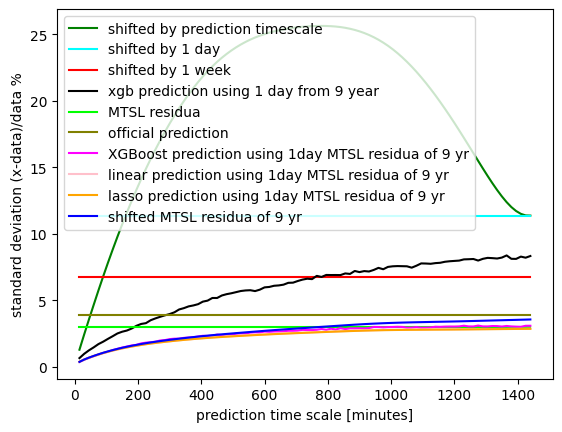

In [51]:

err=100*np.std(power_test_pred-power_test)/np.mean(power_test)
print(err)
plt.plot(pred_from_9years[0],100*pred_from_9years[1]/pred_from_9years[3],'-',ms=1,color='green',label='shifted by prediction timescale') 
plt.plot(pred_from_9years[0],0*pred_from_9years[1]+100*np.std(shift_1day-y_test)/np.mean(y_test),'-',ms=1,color='cyan',label='shifted by 1 day')
plt.plot(pred_from_9years[0],0*pred_from_9years[1]+100*np.std(shift_1week-y_test)/np.mean(y_test),'-',ms=1,color='red',label='shifted by 1 week') 
plt.plot(pred_from_9years[0],100*pred_from_9years[2]/pred_from_9years[3],'-',ms=1,color='black',label='xgb prediction using 1 day from 9 year')
#plt.plot(pred_from_2years[0],100*pred_from_2years[2]/pred_from_2years[3],'-',ms=1,color='blue',label='prediction using 1 day from 1.5 years') 
plt.plot(pred_from_9years[0],0*pred_from_9years[1]+100*np.std(residual2_test)/np.mean(power_test),'-',ms=1,color='lime', label='MTSL residua')
plt.plot(pred_from_9years[0],0*pred_from_9years[1]+err,'-',ms=1,color='olive', label='official prediction')
plt.plot(resfm[0],100*resfm[2]/resf8[3],'-',ms=1,color='magenta',label='XGBoost prediction using 1day MTSL residua of 9 yr')
plt.plot(resfl[0],100*resfl[2]/resf8[3],'-',ms=1,color='pink',label='linear prediction using 1day MTSL residua of 9 yr')
plt.plot(resfa1[0],100*resfa1[2]/resf8[3],'-',ms=1,color='orange',label='lasso prediction using 1day MTSL residua of 9 yr')
plt.plot(resfm[0],100*resfm[1]/resf8[3],'-',ms=1,color='blue',label='shifted MTSL residua of 9 yr')
plt.legend(loc="best")
plt.xlabel("prediction time scale [minutes]")
plt.ylabel("standard deviation (x-data)/data %")

All resida fittingmethods arte better than the diredct data method. 
The improvement is smallest on the smallest time scales where the not (well) accounting for the periodicity in the 
other models has no large impact. From about 3 hours onwards the pure MTSL model is better than all methods which do not use it. 

I am now zooming into the better predictions.

relatove to just using zero time offset
worst over fitting factor of xgboost 1.028331
worst over fitting factor of linear regression 0.991683
worst over fitting factor of lasso regression 1.02732
best fitting factor of xgboost 0.849657
best fitting factor of linear regression 0.805188
best fitting factor of lasso regression 0.803132


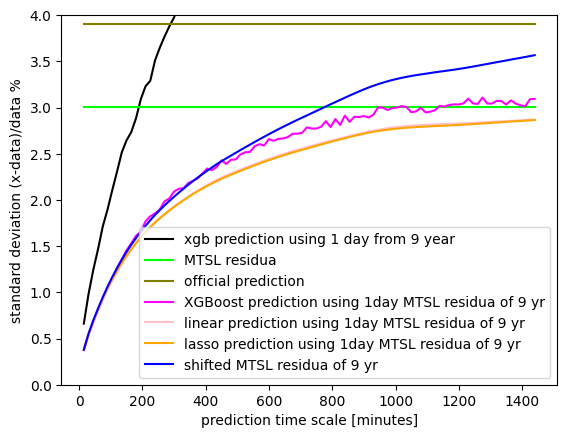

In [52]:
 plt.plot(pred_from_9years[0],100*pred_from_9years[2]/pred_from_9years[3],'-',ms=1,color='black',label='xgb prediction using 1 day from 9 year')
#plt.plot(pred_from_2years[0],100*pred_from_2years[2]/pred_from_2years[3],'-',ms=1,color='blue',label='prediction using 1 day from 1.5 years') 
plt.plot(pred_from_9years[0],0*pred_from_9years[1]+100*np.std(residual2_test)/np.mean(power_test),'-',ms=1,color='lime', label='MTSL residua')
plt.plot(pred_from_9years[0],0*pred_from_9years[1]+err,'-',ms=1,color='olive', label='official prediction')
plt.plot(resfm[0],100*resfm[2]/resf8[3],'-',ms=1,color='magenta',label='XGBoost prediction using 1day MTSL residua of 9 yr')
plt.plot(resfl[0],100*resfl[2]/resf8[3],'-',ms=1,color='pink',label='linear prediction using 1day MTSL residua of 9 yr')
plt.plot(resfa1[0],100*resfa1[2]/resf8[3],'-',ms=1,color='orange',label='lasso prediction using 1day MTSL residua of 9 yr')
plt.plot(resfm[0],100*resfm[1]/resf8[3],'-',ms=1,color='blue',label='shifted MTSL residua of 9 yr')
plt.legend(loc="best")
plt.xlabel("prediction time scale [minutes]")
plt.ylabel("standard deviation (x-data)/data %")
plt.ylim(0,4)
print("relatove to just using zero time offset")
print(f"worst over fitting factor of xgboost {round(max(resfm[2]/resfm[1]),6)}")
print(f"worst over fitting factor of linear regression {round(max(resfl[2]/resfl[1]),6)}")
print(f"worst over fitting factor of lasso regression {round(max(resfa1[2]/resfa1[1]),6)}")
print(f"best fitting factor of xgboost {round(min(resfm[2]/resfm[1]),6)}")
print(f"best fitting factor of linear regression {round(min(resfl[2]/resfl[1]),6)}")
print(f"best fitting factor of lasso regression {round(min(resfa1[2]/resfa1[1]),6)}")

Linear looks now better than xgboost, good anyway easier to run, optimize and implement.
Lasso very similar to linear, maybe slightly better at largest time scales. We look on that below. 

Compare residua of the doofferent correcting method, concentrating on the best methods and offsets.  



Since there is still some advancetage compared to MTSL only at the end of the timespan, I am now looking 
into longer timescales both predictionwise (how much in the future) and much data is used for prediction.

(0.0, 4.0)

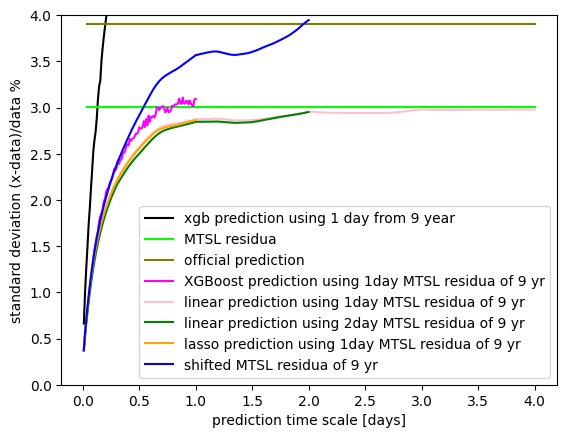

In [54]:
plt.plot(pred_from_9years[0]/60/24,100*pred_from_9years[2]/pred_from_9years[3],'-',ms=1,color='black',label='xgb prediction using 1 day from 9 year')
#plt.plot(pred_from_2years[0],100*pred_from_2years[2]/pred_from_2years[3],'-',ms=1,color='blue',label='prediction using 1 day from 1.5 years') 
plt.plot(pred_from_9years[0]*4/60/24,0*pred_from_9years[1]+100*np.std(residual2_test)/np.mean(power_test),'-',ms=1,color='lime', label='MTSL residua')
plt.plot(pred_from_9years[0]*4/60/24,0*pred_from_9years[1]+err,'-',ms=1,color='olive', label='official prediction')
plt.plot(resfm[0]/60/24,100*resfm[2]/resf8[3],'-',ms=1,color='magenta',label='XGBoost prediction using 1day MTSL residua of 9 yr')
plt.plot(resfl[0]/60/24,100*resfl[2]/resf8[3],'-',ms=1,color='pink',label='linear prediction using 1day MTSL residua of 9 yr')
plt.plot(resflb[0]/60/24,100*resflb[2]/resf8[3,0],'-',ms=1,color='pink')
plt.plot(resflc[0]/60/24,100*resflc[2]/resf8[3,0],'-',ms=1,color='pink')
plt.plot(resfl2[0]/60/24,100*resfl2[2]/resf8[3,0],'-',ms=1,color='green',label='linear prediction using 2day MTSL residua of 9 yr')
plt.plot(resfa1[0]/60/24,100*resfa1[2]/resf8[3],'-',ms=1,color='orange',label='lasso prediction using 1day MTSL residua of 9 yr')
plt.plot(resfl[0]/60/24,100*resfl[1]/resf8[3,0],'-',ms=1,color='blue',label='shifted MTSL residua of 9 yr')
plt.plot(resflb[0]/60/24,100*resflb[1]/resf8[3,0],'-',ms=1,color='blue')
plt.legend(loc="best")
plt.xlabel("prediction time scale [days]")
plt.ylabel("standard deviation (x-data)/data %")
plt.ylim(0,4)

-Perfect prediction with using saved data still not possible, but an approximation which is good should be done.  Needed columns with all cycles. How to consider overturning closeness? 

-For correction since different time frame independent modells, it will look Noisy, which is not a real problem, but not nice, some weighted average combining with pure MTSL will help 


-Think about some addition for Easter date. Maybe some additional model to get residuals in dependence for it? 
And it is only applied for days, when it has an effect? Fow now post fit, later maybe before. 

Now MTSL prediction. 

Past function:

In [56]:
#recontructs the 
#is seasonal third seasonal.iloc[:,2] is year 
#general idea ignore one year of data and get with the others, biggest problem likely weeks 
def reconstruct_seas(data,time):
    data2=data.copy()
    for i in range(100):
        #year
        r=abs(time1[i,3]-time1[:,3])
        s=np.argsort(r)
        c=0
        c2=0 
        c3=0
        ar=np.zeros((3,20))
        ar2=np.zeros((3,20))
        #get quasi equal in year
        while r[s[c]]<0.0000001:
            if s[c]!=i:
                ar[0,c2]=data.iloc[s[c],2]
                ar[1,c2]=time1[s[c],1]
                ar[2,c2]=time1[s[c],2]
                c2+=1
            #exclude itself    
            else:  
                ar2[1,c3]=time1[s[c],1]
                ar2[2,c3]=time1[s[c],2]
                c3+=1
            c+=1    
        #option 1 mean    
        #data2.iloc[i,2]=np.mean(ar[0,0:c2])
        linear=LinearRegression()
        linear.fit(ar[1:3,0:c2].T,ar[0,0:c2])
        print(linear.coef_)
        print(linear.intercept_)
        #option 2 linear regression
        data2.iloc[i,2]=linear.intercept_+linear.coef_[0]*ar2[1,0]+linear.coef_[1]*ar2[2,0]
        #week
        #order by week 
        r2=abs(time1[i,2]-time1[:,2])
        s2=np.argsort(r2)
        c=0
        c2=0 
        c3=0
        ar=np.zeros((4,1000))
        ar2=np.zeros((4,100))
        while r2[s2[c]]<0.0000001:
            if s2[c]!=i and r[s2[c]]<0.04:
                ar[0,c2]=data.iloc[s2[c],1]
                ar[1,c2]=time1[s2[c],1]
                ar[2,c2]=time1[s2[c],2]
                ar[3,c2]=time1[s2[c],3]
                c2+=1
            elif s2[c]==i:  
                ar2[0,c3]=data.iloc[s2[c],1]
                ar2[1,c3]=time1[s2[c],1]
                ar2[2,c3]=time1[s2[c],2] 
                ar2[3,c3]=time1[s2[c],3]                
                c3+=1
            c+=1
        print(c2)    
        print(ar[0:4,0:c2].T)
        print(ar2[0:4,0:c3].T)
        linear=LinearRegression()
        linear.fit(ar[1:4,0:c2].T,ar[0,0:c2])
        print(linear.coef_)
        print(linear.intercept_)
        data2.iloc[i,1]=np.mean(ar[0,0:c2])
        data2.iloc[i,1]=linear.intercept_+linear.coef_[0]*ar2[1,0]+linear.coef_[1]*ar2[2,0]+linear.coef_[2]*ar2[3,0]
    return data2

In [58]:
data2=reconstruct_seas(seasonal2,time1)

[-0.00022412  0.00609413]
-2.0405006567876702
18
[[0.35713278 0.         0.         0.01574264]
 [0.37941569 0.         0.         0.0349076 ]
 [0.42720472 0.         0.         0.03696099]
 [0.42469108 0.         0.         0.01779603]
 [0.61996111 0.         0.         0.0109514 ]
 [0.64720084 0.         0.         0.03011636]
 [0.46786107 0.         0.         0.03832991]
 [0.47614339 0.         0.         0.03353867]
 [0.47377524 0.         0.         0.01437372]
 [0.53447359 0.         0.         0.02464066]
 [0.5408691  0.         0.         0.0054757 ]
 [0.54733952 0.         0.         0.00889802]
 [0.56316091 0.         0.         0.02806297]
 [0.24234969 0.         0.         0.02121834]
 [0.20263788 0.         0.         0.00205339]
 [0.48932419 0.         0.         0.01232033]
 [0.48375387 0.         0.         0.03148528]
 [0.46880813 0.         0.         0.01916496]]
[[0.46947915 0.         0.         0.        ]]
[0.         0.         1.30229486]
0.4357427133935836
[0

18
[[0.52655485 0.10416667 0.01488095 0.01945015]
 [0.52276727 0.10416667 0.01488095 0.0386151 ]
 [0.34978141 0.10416667 0.01488095 0.01602783]
 [0.35886067 0.10416667 0.01488095 0.03519279]
 [0.46823501 0.10416667 0.01488095 0.03177048]
 [0.47194173 0.10416667 0.01488095 0.01260552]
 [0.53434961 0.10416667 0.01488095 0.02834816]
 [0.27724541 0.10416667 0.01488095 0.02150354]
 [0.25530483 0.10416667 0.01488095 0.00233858]
 [0.51475627 0.10416667 0.01488095 0.00918321]
 [0.57098178 0.10416667 0.01488095 0.00576089]
 [0.5645886  0.10416667 0.01488095 0.02492585]
 [0.66124183 0.10416667 0.01488095 0.03040155]
 [0.55100232 0.10416667 0.01488095 0.01465891]
 [0.53990247 0.10416667 0.01488095 0.03382386]
 [0.61461539 0.10416667 0.01488095 0.0112366 ]
 [0.38319238 0.10416667 0.01488095 0.03724618]
 [0.38528861 0.10416667 0.01488095 0.01808122]]
[[5.29848884e-01 1.04166667e-01 1.48809524e-02 2.85192790e-04]]
[-3.43076891e+11 -4.90123995e+10  1.25473022e-01]
36466527308.31577
[0.00669923 0.0118

[ 1.83000275e+13 -1.28089747e+14 -7.81250000e-01]
-341978719.1287007
[-0.02189411  0.02363772]
-2.499029476839985
18
[[0.77095814 0.23958333 0.03422619 0.0198209 ]
 [0.77684093 0.23958333 0.03422619 0.03898585]
 [0.66204904 0.23958333 0.03422619 0.03556354]
 [0.6346254  0.23958333 0.03422619 0.01639859]
 [0.93219541 0.23958333 0.03422619 0.01297627]
 [0.93824621 0.23958333 0.03422619 0.03214123]
 [0.69501424 0.23958333 0.03422619 0.02187429]
 [1.03356343 0.23958333 0.03422619 0.00955396]
 [1.0417114  0.23958333 0.03422619 0.02871891]
 [0.97084107 0.23958333 0.03422619 0.0252966 ]
 [0.96911169 0.23958333 0.03422619 0.00613164]
 [0.67048629 0.23958333 0.03422619 0.00270933]
 [0.9616947  0.23958333 0.03422619 0.01160735]
 [0.84415255 0.23958333 0.03422619 0.01502966]
 [0.68175377 0.23958333 0.03422619 0.03761693]
 [0.67986271 0.23958333 0.03422619 0.01845197]
 [0.82984122 0.23958333 0.03422619 0.03419462]
 [1.00331562 0.23958333 0.03422619 0.0307723 ]]
[[7.65578308e-01 2.39583333e-01 3.42

18
[[1.04554021 0.35416667 0.05059524 0.02013461]
 [1.06302906 0.35416667 0.05059524 0.03929957]
 [1.05228215 0.35416667 0.05059524 0.0167123 ]
 [1.09653583 0.35416667 0.05059524 0.03587725]
 [1.39255194 0.35416667 0.05059524 0.03245494]
 [1.39872659 0.35416667 0.05059524 0.01328998]
 [1.56185225 0.35416667 0.05059524 0.00986767]
 [1.13902544 0.35416667 0.05059524 0.00302304]
 [1.46540994 0.35416667 0.05059524 0.00644536]
 [1.56734937 0.35416667 0.05059524 0.02903263]
 [1.16179111 0.35416667 0.05059524 0.022188  ]
 [1.4707111  0.35416667 0.05059524 0.02561031]
 [1.30222827 0.35416667 0.05059524 0.03108601]
 [0.96316897 0.35416667 0.05059524 0.01876569]
 [0.97725259 0.35416667 0.05059524 0.03793064]
 [1.22115314 0.35416667 0.05059524 0.03450833]
 [1.23497759 0.35416667 0.05059524 0.01534337]
 [1.26110823 0.35416667 0.05059524 0.01192106]]
[[1.02926607e+00 3.54166667e-01 5.05952381e-02 9.69655487e-04]]
[ 4.12556624e+13 -2.83894803e+14 -2.50000000e+00]
-247655278281.07593
[-0.04151531  0.

18
[[0.74613675 0.47916667 0.06845238 0.02047684]
 [0.75687935 0.47916667 0.06845238 0.0396418 ]
 [0.68078552 0.47916667 0.06845238 0.03621948]
 [0.66107506 0.47916667 0.06845238 0.01705453]
 [0.87840784 0.47916667 0.06845238 0.01363222]
 [0.85402051 0.47916667 0.06845238 0.03279717]
 [1.09837543 0.47916667 0.06845238 0.0102099 ]
 [1.109979   0.47916667 0.06845238 0.02937486]
 [1.01116585 0.47916667 0.06845238 0.02595254]
 [0.7906948  0.47916667 0.06845238 0.00336527]
 [0.80603622 0.47916667 0.06845238 0.02253023]
 [1.00486788 0.47916667 0.06845238 0.00678759]
 [0.65308908 0.47916667 0.06845238 0.01910792]
 [0.65880933 0.47916667 0.06845238 0.03827287]
 [0.90817783 0.47916667 0.06845238 0.01226329]
 [0.87518286 0.47916667 0.06845238 0.0156856 ]
 [0.93508375 0.47916667 0.06845238 0.03142825]
 [0.87020132 0.47916667 0.06845238 0.03485056]]
[[0.73610138 0.47916667 0.06845238 0.00131189]]
[ 1.48005236e+13 -1.00774468e+14 -2.28125000e+00]
-193665269155.47803
[-0.03040508  0.04066618]
-2.566

19
[[9.90964259e-01 6.04166667e-01 8.63095238e-02 2.08190737e-02]
 [1.00252464e+00 6.04166667e-01 8.63095238e-02 3.99840292e-02]
 [7.95236451e-01 6.04166667e-01 8.63095238e-02 1.73967602e-02]
 [8.33885323e-01 6.04166667e-01 8.63095238e-02 3.65617157e-02]
 [1.05644464e+00 6.04166667e-01 8.63095238e-02 3.31394022e-02]
 [1.06763522e+00 6.04166667e-01 8.63095238e-02 1.39744467e-02]
 [8.46200292e-01 6.04166667e-01 8.63095238e-02 3.70750627e-03]
 [1.19088532e+00 6.04166667e-01 8.63095238e-02 1.05521332e-02]
 [8.63487256e-01 6.04166667e-01 8.63095238e-02 2.28724618e-02]
 [1.14315757e+00 6.04166667e-01 8.63095238e-02 7.12981976e-03]
 [1.20416015e+00 6.04166667e-01 8.63095238e-02 2.97170888e-02]
 [1.15222965e+00 6.04166667e-01 8.63095238e-02 2.62947753e-02]
 [9.35563760e-01 6.04166667e-01 8.63095238e-02 1.26055213e-02]
 [9.22005006e-01 6.04166667e-01 8.63095238e-02 1.60278348e-02]
 [9.04213417e-01 6.04166667e-01 8.63095238e-02 3.51927903e-02]
 [9.56992902e-01 6.04166667e-01 8.63095238e-02 3.177

[0.02038102 0.01495586]
-2.4154377529329634
19
[[9.90758336e-01 7.18750000e-01 1.02678571e-01 3.00308008e-02]
 [8.01896563e-01 7.18750000e-01 1.02678571e-01 4.02121834e-03]
 [1.03481938e+00 7.18750000e-01 1.02678571e-01 2.66084873e-02]
 [8.35909876e-01 7.18750000e-01 1.02678571e-01 3.55065024e-02]
 [1.03821119e+00 7.18750000e-01 1.02678571e-01 7.44353183e-03]
 [7.49186803e-01 7.18750000e-01 1.02678571e-01 1.29192334e-02]
 [5.77931360e-01 7.18750000e-01 1.02678571e-01 1.97638604e-02]
 [9.93368169e-01 7.18750000e-01 1.02678571e-01 1.08658453e-02]
 [6.07664966e-01 7.18750000e-01 1.02678571e-01 5.98904860e-04]
 [9.86747702e-01 7.18750000e-01 1.02678571e-01 1.42881588e-02]
 [7.73782595e-01 7.18750000e-01 1.02678571e-01 3.20841889e-02]
 [7.93036635e-01 7.18750000e-01 1.02678571e-01 2.11327858e-02]
 [5.80934464e-01 7.18750000e-01 1.02678571e-01 3.89288159e-02]
 [8.01007462e-01 7.18750000e-01 1.02678571e-01 4.02977413e-02]
 [8.03322795e-01 7.18750000e-01 1.02678571e-01 2.31861739e-02]
 [6.5500

[-6.70979624e+14  4.68857894e+15  0.00000000e+00]
985526200564.2863
[ 0.02135592 -0.0242566 ]
-2.3569294834774337
19
[[0.38185542 0.84375    0.12053571 0.03927105]
 [0.3953791  0.84375    0.12053571 0.00094114]
 [0.77984991 0.84375    0.12053571 0.02352841]
 [0.78186327 0.84375    0.12053571 0.02147502]
 [0.69505809 0.84375    0.12053571 0.03242642]
 [0.78279063 0.84375    0.12053571 0.00436345]
 [0.37262459 0.84375    0.12053571 0.02010609]
 [0.46582963 0.84375    0.12053571 0.0180527 ]
 [0.50682726 0.84375    0.12053571 0.03721766]
 [0.8926343  0.84375    0.12053571 0.01463039]
 [0.8682353  0.84375    0.12053571 0.01120808]
 [0.90132528 0.84375    0.12053571 0.03379535]
 [0.78843995 0.84375    0.12053571 0.04063997]
 [0.66162416 0.84375    0.12053571 0.01326146]
 [0.86884477 0.84375    0.12053571 0.03037303]
 [0.91810064 0.84375    0.12053571 0.00778576]
 [0.8298903  0.84375    0.12053571 0.03584873]
 [0.84170123 0.84375    0.12053571 0.01668378]
 [0.90895967 0.84375    0.12053571 0.

[ 8.59573119e+12 -5.61367757e+13  6.32812500e-01]
-546181814410.01355
[-0.00041805 -0.00327197]
-2.0359835895813077
19
[[0.54083557 0.95833333 0.13690476 0.02178873]
 [0.54162534 0.95833333 0.13690476 0.04095368]
 [0.31819465 0.95833333 0.13690476 0.01836642]
 [0.32906055 0.95833333 0.13690476 0.03753137]
 [0.5175165  0.95833333 0.13690476 0.03410906]
 [0.50509713 0.95833333 0.13690476 0.0149441 ]
 [0.49523438 0.95833333 0.13690476 0.03068674]
 [0.55809313 0.95833333 0.13690476 0.00809948]
 [0.48561563 0.95833333 0.13690476 0.01152179]
 [0.56309527 0.95833333 0.13690476 0.02726443]
 [0.49024463 0.95833333 0.13690476 0.00467716]
 [0.46305781 0.95833333 0.13690476 0.02384212]
 [0.57087    0.95833333 0.13690476 0.01699749]
 [0.35966777 0.95833333 0.13690476 0.03274013]
 [0.34130877 0.95833333 0.13690476 0.01357518]
 [0.22236288 0.95833333 0.13690476 0.0204198 ]
 [0.26279302 0.95833333 0.13690476 0.00125485]
 [0.55106182 0.95833333 0.13690476 0.03616245]
 [0.2068328  0.95833333 0.13690476 

In [59]:
#for first 100, average better than interpolated for year and week for 8 
#week 0.02 0.16, 0.04 is 0.12 scatter is better but need to test whether it is a fair test, 
#should exclude consecutive longer period
print(np.std(seasonal.iloc[0:100,2]-data2.iloc[0:100,2]))
print(np.std(seasonal.iloc[0:100,1]-data2.iloc[0:100,1]))

0.08554047907860007
0.11663024089063592


Text(0, 0.5, 'value')

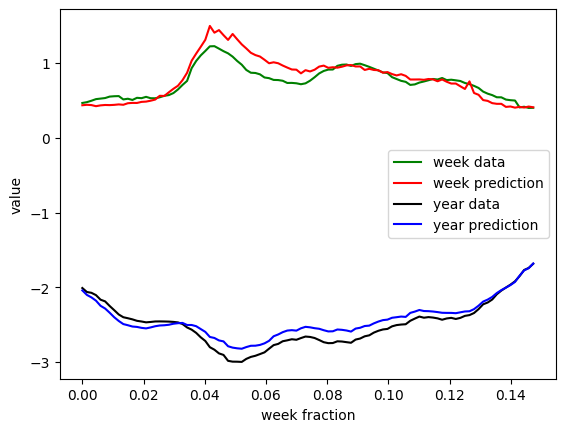

In [60]:
x=100
plt.plot(time1[0:x,2],seasonal.iloc[0:x,1],'-',ms=1,color='green',label='week data') 
plt.plot(time1[0:x,2],data2.iloc[0:x,1],'-',ms=1,color='red',label='week prediction') 
plt.plot(time1[0:x,2],seasonal.iloc[0:x,2],'-',ms=1,color='black',label='year data') 
plt.plot(time1[0:x,2],data2.iloc[0:x,2],'-',ms=1,color='blue',label='year prediction') 
plt.legend(loc="best")
plt.xlabel("week fraction")
plt.ylabel("value")
#now about correct

Now new function for prediction. 

In [78]:

#is seasonal third seasonal.iloc[:,2] is year 
#general idea ignore one year of data and get with the others, biggest problem likely weeks 
def reconstruct_seas2(data,time,start=0,stop=10):
    data2=data.copy()
    for i in range(start,stop):
        #make copy exclude current
        nowdat=np.zeros((data2.shape[0]-1,3))
        nowtime=np.zeros((time.shape[0]-1,5))
        mtime=time[i,:]
        if i==0:
            nowdat[:,:]=data2.iloc[i+1:,:]
            nowtime[:,:]=time[i+1:,:]
        else:
            nowdat[0:i,:]=data2.iloc[0:i,:]
            nowtime[i:,:]=time[i+1:,:]            
        #year
        r=abs(mtime[3]-nowtime[:,3])
        s=np.argsort(r)
        #week
        rw=abs(mtime[2]-nowtime[:,2])
        sw=np.argsort(rw)        
        #day
        rd=abs(mtime[1]-nowtime[:,1])
        sd=np.argsort(rd)   
        #closest of all togther should be choosen mean also only one to sort
        ra=abs(mtime[3]-nowtime[:,3])+abs(mtime[2]-nowtime[:,2])+abs(mtime[1]-nowtime[:,1])
        sa=np.argsort(ra)
        print(sa[0:5])
        c=0
        c2=0 
        c3=0
        ar=np.zeros((3,20))
        ar2=np.zeros((3,20))
        #get quasi equal in year
        while r[s[c]]<0.0000001:
            if s[c]!=i:
                ar[0,c2]=data.iloc[s[c],2]
                ar[1,c2]=time1[s[c],1]
                ar[2,c2]=time1[s[c],2]
                c2+=1
            #exclude itself    
            else:  
                ar2[1,c3]=time1[s[c],1]
                ar2[2,c3]=time1[s[c],2]
                c3+=1
            c+=1    
        #option 1 mean    
        #data2.iloc[i,2]=np.mean(ar[0,0:c2])
        linear=LinearRegression()
        linear.fit(ar[1:3,0:c2].T,ar[0,0:c2])
        #print(linear.coef_)
        #print(linear.intercept_)
        #option 2 linear regression
        data2.iloc[i,2]=linear.intercept_+linear.coef_[0]*ar2[1,0]+linear.coef_[1]*ar2[2,0]
        #week
        #order by week 
        r2=abs(time1[i,2]-time1[:,2])
        s2=np.argsort(r2)
        c=0
        c2=0 
        c3=0
        ar=np.zeros((4,1000))
        ar2=np.zeros((4,100))
        while r2[s2[c]]<0.0000001:
            if s2[c]!=i and r[s2[c]]<0.04:
                ar[0,c2]=data.iloc[s2[c],1]
                ar[1,c2]=time1[s2[c],1]
                ar[2,c2]=time1[s2[c],2]
                ar[3,c2]=time1[s2[c],3]
                c2+=1
            elif s2[c]==i:  
                ar2[0,c3]=data.iloc[s2[c],1]
                ar2[1,c3]=time1[s2[c],1]
                ar2[2,c3]=time1[s2[c],2] 
                ar2[3,c3]=time1[s2[c],3]                
                c3+=1
            c+=1
        #print(c2)    
        #print(ar[0:4,0:c2].T)
        #print(ar2[0:4,0:c3].T)
        linear=LinearRegression()
        linear.fit(ar[1:4,0:c2].T,ar[0,0:c2])
        #print(linear.coef_)
        #print(linear.intercept_)
        data2.iloc[i,1]=np.mean(ar[0,0:c2])
        data2.iloc[i,1]=linear.intercept_+linear.coef_[0]*ar2[1,0]+linear.coef_[1]*ar2[2,0]+linear.coef_[2]*ar2[3,0]
    return data2

In [79]:
#closets year as it should 
data2=reconstruct_seas2(seasonal2,time1)

[175391 140447 105503 280895      0]
[175392 140448 105504 280896      0]
[175393 140449 105505 280897      2]
[175394 140450 105506 280898      3]
[175395 140451 105507 280899      4]
[175396 140452 105508 280900      5]
[175397 140453 105509 280901      6]
[175398 140454 105510 280902      7]
[175399 140455 105511 280903      8]
[175400 140456 105512 280904      9]


In [71]:
print(time1.shape)

(315744, 5)
